In [7]:
import numpy as np
import matplotlib.pyplot as plt

## Solving for the optimal exercise boundary

### The Integral Equation

$$
S_f(t) - K = M_1(S_f(t), T-t, K) + \int_t^{T}Q_1(S_f(t), t, u, S_f(u)) du
$$

$$
Q_1(x,y,z,w) = x\delta e^{-\delta(z - y)} \Phi(d_1(x, z-y, w))
- rKe^{-r(z-y)}\Phi(d_2(x, z-y, w))
$$

$$
M_1(x,y,z) = xe^{-\delta y} \Phi (d_1(x,y,z)) - z e^{-ry}\Phi(d_2(x,y,z))
$$

$$
d_1(x, y, z) = \frac{\ln(x/z) + (r - \delta + \sigma^2/2)y}{\sigma\sqrt{y}}
$$

$$
d_2(x, y, z) = d_1(x,y,z)-\sigma\sqrt{y}
$$

$$
1_{(S=S_f)}(S) =
\begin{cases}
\frac{1}{2} & \textrm{if } S = S_f(t) \\ 
0 & \textrm{otherwise}
\end{cases}
$$

### Parameters

In [2]:
dividend = 0.02
strike_price = 100
volatility = 0.2
risk_free_rate = 0.05
time_to_maturity = 1

### Computation of necessary functions

In [3]:
from scipy.special import erf

# The CDF of the standard normal distribution
def phi(z):
    return (1.0 + erf(z / np.sqrt(2.0))) / 2.0

def d1(x, y, z):
    return (np.log(x / z) + (risk_free_rate - dividend + volatility ** 2 / 2) * y) / (volatility * np.sqrt(y))

def d2(x, y, z):
    return d1(x, y, z) - volatility * np.sqrt(y)

def Q1(x, y, z, w):
    x = float(x)
    result = x * dividend * np.exp(-dividend * (z - y)) * phi(d1(x, z - y, w))
    result -= risk_free_rate * strike_price * np.exp(-risk_free_rate * (z - y)) * phi(d2(x, z - y, w))
    return result

def Q1_derivative_x(x, y, z, w):
    # Derivative of Q1 with respect to x using five-point stencil method
    h = 1e-5
    return (-Q1(x + 2*h, y, z, w) + 8*Q1(x + h, y, z, w) - 8*Q1(x - h, y, z, w) + Q1(x - 2*h, y, z, w)) / (12 * h)

def M1(x, y, z):
    x = float(x)
    result = x * np.exp(-dividend * y) * phi(d1(x, y, z)) - strike_price * np.exp(-risk_free_rate * y) * phi(d2(x, y, z))
    return result

def M1_derivative_x(x, y, z):
    # Derivative of M1 with respect to x using five-point stencil method
    h = 1e-5
    return (-M1(x + 2*h, y, z) + 8*M1(x + h, y, z) - 8*M1(x - h, y, z) + M1(x - 2*h, y, z)) / (12 * h)

### The Newton Raphson procedure

In [11]:
# Newton-Raphson method
def newton_raphson(f, f_prime, x0, tol=1e-7, max_iter=100):
    x = x0
    n_iter = 0
    for _ in range(max_iter):
        n_iter += 1
        fx = f(x)
        fpx = f_prime(x)
        if abs(fpx) < tol:
            raise ValueError("Derivative too small; no convergence.")
        x_new = x - fx / fpx
        if abs(x_new - x) < tol:
            return x_new
        x = x_new
    print(f"Did not converge in {max_iter} iterations.")
    return x

### Computing the solution

In [12]:
time_discretization = np.linspace(0, time_to_maturity, 252)
s_f_list = []
s_f_list.append([0] * len(time_discretization))
s_f_list = s_f_list[0]

s_f_list[-1] = max(strike_price, risk_free_rate * strike_price / dividend)
n_steps = len(time_discretization) - 1
cumulative = 0
cnt=0
for i in range(len(time_discretization) - 2, -1, -1):
    time_passed = i / n_steps
    guess_x = s_f_list[i + 1] 
    def test_sf(x):
        test_result =  x - strike_price - M1(x, 1-time_passed, strike_price)
        test_result -= (1/(n_steps * 2)) * Q1(x, time_passed, time_passed + 1.0/n_steps, s_f_list[i + 1])
        test_result -= (1/(n_steps * 2)) * (1/2 * x * dividend - 1/2 * risk_free_rate * strike_price)
        for j in range(i + 1, len(time_discretization) - 1, 1):
            test_result -= (1/(n_steps * 2)) * Q1(x, time_passed, j/n_steps, s_f_list[j])
            test_result -= (1/(n_steps * 2)) * Q1(x, time_passed, (j + 1)/n_steps, s_f_list[j + 1])
        return test_result
    def test_sf_derivative(x):
        derivative_result = 1 - M1_derivative_x(x, 1 - time_passed, strike_price)
        derivative_result -= (1/(n_steps*2)) * Q1_derivative_x(x, time_passed, time_passed + 1.0/n_steps, s_f_list[i + 1])
        derivative_result -= (1/(n_steps*2)) * 1/2 * dividend
        for j in range(i + 1, len(time_discretization) - 1):
            derivative_result -= (1/(n_steps * 2)) * Q1_derivative_x(x, time_passed, j/n_steps, s_f_list[j])
            derivative_result -= (1/(n_steps * 2)) * Q1_derivative_x(x, time_passed, (j + 1)/n_steps, s_f_list[j + 1])
        return derivative_result
    
    s_f_list[i] = newton_raphson(test_sf, test_sf_derivative, guess_x)



Text(0.5, 0, 'Date')

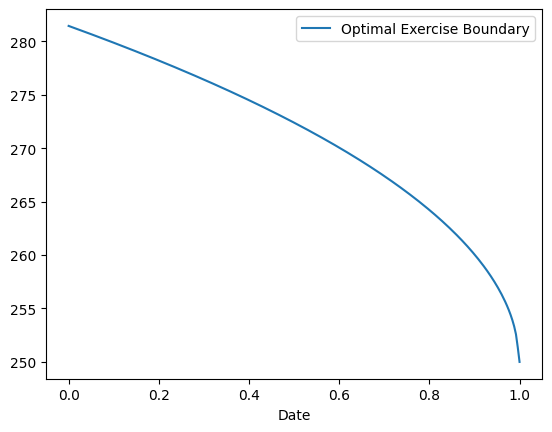

In [13]:
# Graph the stock price and the optimal exercise boundary
plt.plot(time_discretization, s_f_list, label='Optimal Exercise Boundary')
plt.legend()
plt.xlabel('Date')